In [10]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from collections import Counter

pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

In [14]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)

def print_statistics(y_test, y_pred,i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))

def train_pred(X, y, save=False, dop=""):
    cv = StratifiedKFold(5,shuffle = False)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        print(X_train[range(5),range(5)])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        class_model = GradientBoostingClassifier(n_estimators=200,max_features='sqrt',random_state=2021).fit(X_train, y_train)
#         y_pred = class_model.predict(X_test)
                
        y_hat = class_model.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = class_model.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(class_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, class_model.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "svm_rocaoc_{}_{}.pdf".format(dop,save)))
    plt.show()
    return aucs


In [21]:
data["result"][::3].to_numpy().shape

(896,)

========== Dog_1_reduced ==========
[   31.38554  -428.0891     17.9564  -1303.395      19.84129]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[   15.67629 -1096.402      19.09728  -154.7724     18.33961]
  0  ,    0.4004     ,    0.7692     ,    0.4182     ,    0.0612     ,    0.1133     
  0  ,    0.9590     ,    0.0000     ,    0.9126     ,    0.0000     ,      nan      
[   31.38554  -428.0891     17.9564  -1303.395      19.84129]


<ipython-input-14-59bfd1ef5c4b>:18: RuntimeWarning: invalid value encountered in double_scalars
  f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))


  1  ,    0.4258     ,    0.4615     ,    0.4275     ,    0.0392     ,    0.0723     
  1  ,    0.9023     ,    0.0000     ,    0.8587     ,    0.0000     ,      nan      
[   31.38554  -428.0891     17.9564  -1303.395      19.84129]


<ipython-input-14-59bfd1ef5c4b>:18: RuntimeWarning: invalid value encountered in double_scalars
  f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))


  2  ,    0.5645     ,    0.8846     ,    0.5799     ,    0.0935     ,    0.1691     
  2  ,    0.9355     ,    0.2692     ,    0.9033     ,    0.1750     ,    0.2121     
[   31.38554  -428.0891     17.9564  -1303.395      19.84129]
  3  ,    0.5254     ,    0.7200     ,    0.5345     ,    0.0690     ,    0.1259     
  3  ,    0.9180     ,    0.2000     ,    0.8845     ,    0.1064     ,    0.1389     
[   31.38554  -428.0891     17.9564  -1303.395      19.84129]
  4  ,    0.4707     ,    0.7600     ,    0.4842     ,    0.0655     ,    0.1206     
  4  ,    0.9238     ,    0.1200     ,    0.8864     ,    0.0714     ,    0.0896     
              precision    recall  f1-score   support

         0.0       0.97      0.48      0.64      2560
         1.0       0.06      0.72      0.12       128

    accuracy                           0.49      2688
   macro avg       0.52      0.60      0.38      2688
weighted avg       0.93      0.49      0.62      2688



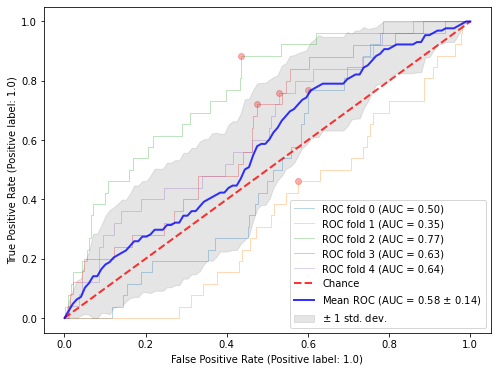

[0.4981219951923077, 0.3500600961538462, 0.7705829326923077, 0.629609375, 0.6353125]
0.5767373798076924
========== Dog_2_reduced ==========
[1736.04119811   23.28086513 1162.43056624   20.97122559 -594.67257696]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[ 820.22480135   16.95077311  358.15699717   15.76132846 -753.04963377]
  0  ,    0.6966     ,    0.9091     ,    0.7128     ,    0.1980     ,    0.3252     
  0  ,    0.8989     ,    0.4773     ,    0.8668     ,    0.2800     ,    0.3529     
[1736.04119811   23.28086513 1162.43056624   20.97122559 -594.67257696]
  1  ,    0.8443     ,    0.9111     ,    0.8495     ,    0.3306     ,    0.4852     
  1  ,    0.9156     ,    0.4889     ,    0.8824     ,    0.3284     ,    0.3929     
[1736.04119811   23.28086513 1162.43056624   20.97122559 -594.67257696]
  2  ,    0.7336     ,    0.8889     ,    0.7457     ,    0.2198     ,    0.3524     
  2  ,    0.9606     ,    0.1556     ,    0.8979     ,  

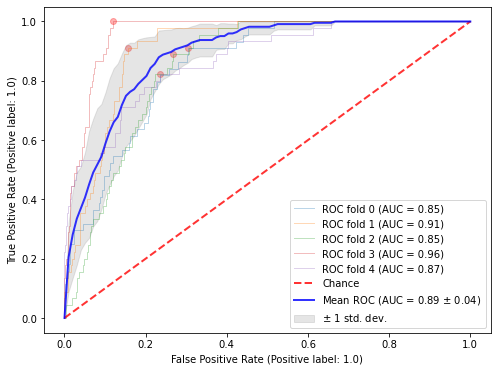

[0.8538474633980252, 0.9102355638941004, 0.8530331457160725, 0.9607671461329997, 0.8710860954763394]
0.8897938829235075
========== Dog_3_reduced ==========
[  18.49384    29.66389  1566.953      39.46827     3.191291]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[28.79308  42.3432   94.82147  42.31448   6.716692]
  0  ,    0.7012     ,    0.8052     ,    0.7061     ,    0.1190     ,    0.2074     
  0  ,    0.9870     ,    0.0909     ,    0.9442     ,    0.2593     ,    0.1346     
[  18.49384    29.66389  1566.953      39.46827     3.191291]
  1  ,    0.8717     ,    0.7013     ,    0.8636     ,    0.2151     ,    0.3293     
  1  ,    0.9922     ,    0.4156     ,    0.9647     ,    0.7273     ,    0.5289     
[  18.49384    29.66389  1566.953      39.46827     3.191291]
  2  ,    0.9505     ,    0.9870     ,    0.9523     ,    0.5000     ,    0.6638     
  2  ,    0.9564     ,    0.9481     ,    0.9560     ,    0.5214     ,    0.6728     
[  1

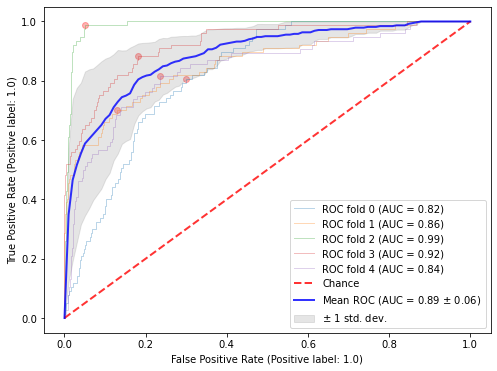

[0.8238213609307359, 0.8596624729437229, 0.9879261363636364, 0.9247750946969697, 0.8426192434210525]
0.8877608616712234
========== Dog_4_reduced ==========
[  6.461733 118.3472   105.3744   119.6074     7.091007]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[   4.99729  2220.505      85.20336    83.17807     5.994639]
  0  ,    0.2529     ,    0.5096     ,    0.2807     ,    0.0764     ,    0.1328     
  0  ,    0.8497     ,    0.0673     ,    0.7651     ,    0.0515     ,    0.0583     
[  6.461733 118.3472   105.3744   119.6074     7.091007]
  1  ,    0.6154     ,    0.7885     ,    0.6341     ,    0.1990     ,    0.3178     
  1  ,    0.8182     ,    0.2981     ,    0.7620     ,    0.1658     ,    0.2131     
[  6.461733 118.3472   105.3744   119.6074     7.091007]
  2  ,    0.5513     ,    0.7500     ,    0.5728     ,    0.1685     ,    0.2751     
  2  ,    0.8846     ,    0.3750     ,    0.8295     ,    0.2826     ,    0.3223     
[  6.4617

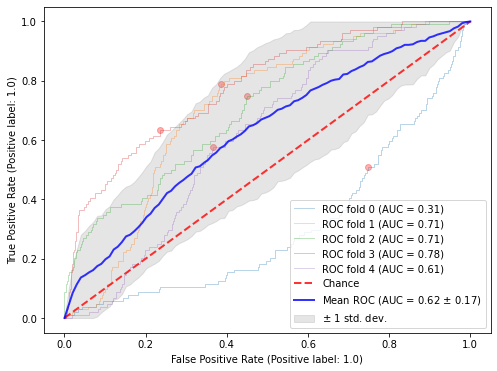

[0.30713197059350905, 0.7086919490765644, 0.7092186659494352, 0.7806862041109416, 0.6145206893456602]
0.6240498958152221
========== Dog_5_reduced ==========
[  19.84988012   39.10566301 4084.34499615   48.02581732    4.55780831]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[ 20.10024551  21.43833037 815.52102356  20.79644166   3.32965978]
  0  ,    0.8667     ,    0.9688     ,    0.8730     ,    0.3263     ,    0.4882     
  0  ,    0.9396     ,    0.5312     ,    0.9141     ,    0.3696     ,    0.4359     
[  19.84988012   39.10566301 4084.34499615   48.02581732    4.55780831]
  1  ,    0.9917     ,    0.9375     ,    0.9883     ,    0.8824     ,    0.9091     
  1  ,    0.9979     ,    0.6875     ,    0.9785     ,    0.9565     ,    0.8000     
[  19.84988012   39.10566301 4084.34499615   48.02581732    4.55780831]
  2  ,    0.8979     ,    0.9062     ,    0.8984     ,    0.3718     ,    0.5273     
  2  ,    0.9938     ,    0.5625     ,    0.

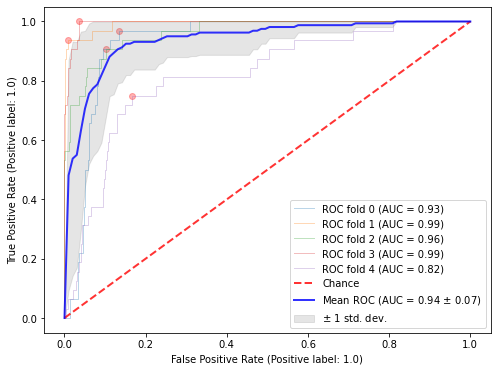

[0.9332682291666667, 0.9932291666666666, 0.963671875, 0.9947916666666666, 0.81875]
0.9407421874999999
========== Patient_1_reduced ==========
[ 2.91552995  3.14155456 34.79409307 43.49544116 44.70195176]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[ 2.74116614  2.99846726 66.89054272 96.16635438 83.05660299]
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    0.7455     ,    1.0000     ,    0.8133     ,    0.5882     ,    0.7407     
[ 2.91552995  3.14155456 34.79409307 43.49544116 44.70195176]
  1  ,    0.8000     ,    1.0000     ,    0.8533     ,    0.6452     ,    0.7843     
  1  ,    0.8909     ,    0.7500     ,    0.8533     ,    0.7143     ,    0.7317     
[ 2.91552995  3.14155456 34.79409307 43.49544116 44.70195176]
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
[ 2.9155

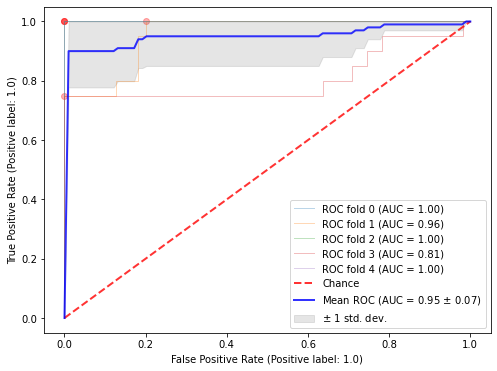

[1.0, 0.9563636363636364, 1.0, 0.8072727272727273, 1.0]
0.9527272727272728
========== Patient_2_reduced ==========
[  5.79951201   6.48939183  81.78026605 104.91523621 106.65775377]
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
[  6.33386874   5.69472256  82.83041832 105.06875126 108.96067123]
  0  ,    0.9362     ,    0.9474     ,    0.9394     ,    0.8571     ,    0.9000     
  0  ,    0.9149     ,    0.9474     ,    0.9242     ,    0.8182     ,    0.8780     
[  5.79951201   6.48939183  81.78026605 104.91523621 106.65775377]
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    0.9000     ,    0.9697     ,    1.0000     ,    0.9474     
[  5.79951201   6.48939183  81.78026605 104.91523621 106.65775377]
  2  ,    0.2609     ,    1.0000     ,    0.4848     ,    0.3704     ,    0.5405     
  2  ,    0.2826     ,    0.5000     ,    0.3485     ,    0.2326     ,    0.3175     
[  5.79951201  

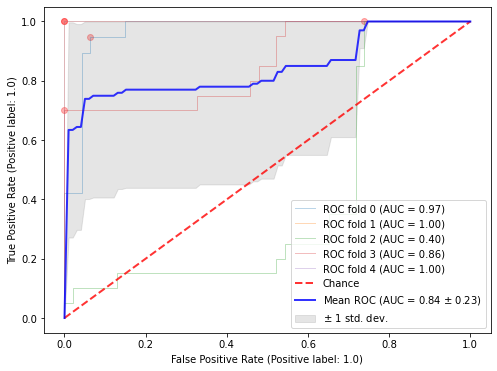

[0.9686450167973124, 1.0, 0.4043478260869565, 0.8576086956521739, 1.0]
0.8461203077072886


In [16]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    print(data_x[range(5),range(5)])
    aucs = train_pred(data_x, data_y)
    print(aucs)
    print(np.mean(aucs))